In [1]:
from queryportal.dex import Dex
from datetime import datetime
import matplotlib.pyplot as plt
import polars as pl

In [2]:
# define subgraph endpoint. This one is the Univ3 Ethereum endpoint maintained by Messari
endpoint_list = [
                'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum',
                # 'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-polygon', # NOTE - 3/20/23 polygon is disabled, waiting for schema updates so has the correct number of rows.
                'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-arbitrum',
                'https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-optimism'
                 ]

# swap query params
token_in = ['USDC']
# query the first 2500 swaps that occured within the time period.
query_size = 2500

In [3]:
df_data = []

In [4]:
for endpoint in endpoint_list:
    # instantiate dex class. Dex stores dex-related query functions
    my_dex = Dex(endpoint)

    # define swap query
    df = my_dex.query_swaps(
        query_size=query_size,
        token_in=token_in,
        save_data=True,
        add_endpoint_col=True
        )
    
    df_data.append(df)

Shape: (2, 6)
Column Names: ['tokens_id', 'tokens_name', 'tokens_symbol', 'tokens_decimals', 'tokens_lastPriceUSD', 'tokens_lastPriceBlockNumber']
Data Types: [Utf8, Utf8, Utf8, Int64, Float64, Int64]
Data: 
shape: (2, 6)
┌────────────────┬────────────────┬───────────────┬────────────────┬───────────────┬───────────────┐
│ tokens_id      ┆ tokens_name    ┆ tokens_symbol ┆ tokens_decimal ┆ tokens_lastPr ┆ tokens_lastPr │
│ ---            ┆ ---            ┆ ---           ┆ s              ┆ iceUSD        ┆ iceBlockNumbe │
│ str            ┆ str            ┆ str           ┆ ---            ┆ ---           ┆ r             │
│                ┆                ┆               ┆ i64            ┆ f64           ┆ ---           │
│                ┆                ┆               ┆                ┆               ┆ i64           │
╞════════════════╪════════════════╪═══════════════╪════════════════╪═══════════════╪═══════════════╡
│ 0x566957ef80f9 ┆ USD Coin (PoS) ┆ USDC          ┆ 6              ┆ 0.

In [5]:
concat_df = pl.concat(df_data)

In [11]:
# get largest swaps_timestamp
max_timestamp = concat_df['swaps_timestamp'].max()

In [7]:
# check unique addresses. These are all the different addresses of USDC on the different blockchains
concat_df['swaps_tokenIn_id'].unique()

swaps_tokenIn_id
str
"""0x7f5c764cbc14..."
"""0x566957ef80f9..."
"""0xa0b86991c621..."
"""0xff970a61a04b..."


In [8]:
# group by endpoint and sum swaps_amountInUSD
grouped_df = concat_df.groupby(['endpoint']).agg([pl.sum('swaps_amountInUSD')]).sort('swaps_amountInUSD', descending=True)

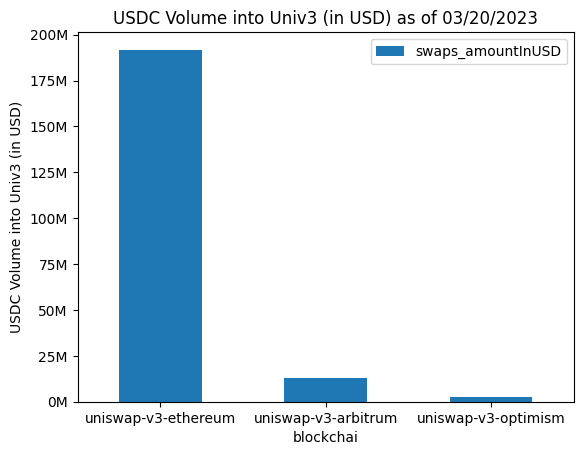

In [13]:
grouped_df.to_pandas().plot.bar(x='endpoint', y='swaps_amountInUSD', rot=0)
plt.xlabel('blockchai')
plt.ylabel('USDC Volume into Univ3 (in USD)')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x/1000000)) + 'M'))
# convert max_timestamp to datetime
my_date = datetime.fromtimestamp(max_timestamp)
plt.title(f'USDC Volume into Univ3 (in USD) as of {my_date.strftime("%m/%d/%Y")}')
# format start_date

plt.show()